## Front Matter

Professional listings in London: Exploring their spatial extent and impact on local areas before and during COVID-19.



CASA0013: Introduction to Programming for Spatial Analysts

Student ID: 19180432

Word count:

---

## Executive summary

Spatial exploration of professional listings? Where are they located? What does this mean for the local areas? Occupancy?


Looking at the disproportionate impact of professional listings versus the humble listings on airbnb. 
- See how their earnings have changed over time?
- Look at the occupancy
- What does this mean for tourism dollars?

---

In [1]:
import os
from requests import get
from urllib.parse import urlparse
import pandas as pd
import geopandas as gpd
import numpy as np
import string

import matplotlib.pyplot as plt


In [2]:
def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

**Data:**

- We will be running a comparative analysis using listing data from December 2019 and 2020

**Reading in December 2020 listing data, selecting cols:**

In [3]:
ddir = os.path.join('data','raw') # create a destination directory where the data will be stored

path = 'https://github.com/Isabella-Brant/i2p_assignment/blob/main/data/raw/16-12-2020-listings.csv.gz'

cols = ['id','listing_url','name','price', 'description', 'host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type', 
        'calculated_host_listings_count_entire_homes', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
        'minimum_nights', 'calculated_host_listings_count_private_rooms']

dec_20 = pd.read_csv(cache_data(path+'?raw=true', ddir),compression='gzip', low_memory=False, usecols=cols)
print(f"Data frame is {dec_20.shape[0]:,} x {dec_20.shape[1]}")

Found data/raw/16-12-2020-listings.csv.gz locally!
Data frame is 77,136 x 17


**Reading in the December 2019 listing data, selecting cols:**

In [4]:
path2 = 'https://github.com/Isabella-Brant/i2p_assignment/blob/main/data/raw/09-12-2019-listings.csv.gz'

cols2 = ['id','listing_url','name','price', 'description', 'host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','calculated_host_listings_count_entire_homes', 
         'number_of_reviews_ltm','minimum_nights','calculated_host_listings_count_private_rooms']
       
dec_19 = pd.read_csv(cache_data(path2+'?raw=true', ddir),compression='gzip', low_memory=False, usecols=cols2)     
print(f"Data frame is {dec_19.shape[0]:,} x {dec_19.shape[1]}")

Found data/raw/09-12-2019-listings.csv.gz locally!
Data frame is 86,469 x 16


**Cleaning the data:**

Now going to clean the data to prepare for analysis.

Cleaning process:
- Then we are going to drop any listings with a NA index.
- Then will drop any listings where the latitude or longitude is a NA value
- Change price to float

Data cleaning functions:

In [5]:
def clean(df):
    df.drop(df[df.id.isna()].index.values, axis=0, inplace=True)
    df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
    df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
    print(f"Data frame now contains {df.shape[0]} rows.")

In [6]:
clean(dec_20)
clean(dec_19)

Data frame now contains 77136 rows.
Data frame now contains 86469 rows.


In [7]:
def price(df):
        df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

In [8]:
price(dec_20)
price(dec_19)

EDA:
- prices are very skewed going to remove top 1% quantile
- may be worth taking these out to avoid skewed analysis using price

In [9]:
#df.price.describe()

Because price is positively skewed, I am going to remove any listings which are in the top 1% quantile:

In [10]:
remove_eh = dec_20[dec_20['room_type'] == 'Entire home/apt'].price.quantile(0.99)

remove_pv = dec_20[dec_20['room_type'] == 'Private room'].price.quantile(0.99)

remove_sr = dec_20[dec_20['room_type'] == 'Shared room'].price.quantile(0.99)

remove_hr = dec_20[dec_20['room_type'] == 'Hotel room'].price.quantile(0.99)

remove_price = dec_20[
    ((dec_20['room_type'] == 'Entire home/apt') & (dec_20['price'] >= remove_eh)) |
    ((dec_20['room_type'] == 'Private room') & (dec_20['price'] >= remove_pv)) |
    ((dec_20['room_type'] == 'Shared room') & (dec_20['price'] >= remove_sr)) |
    ((dec_20['room_type'] == 'Hotel room') & (dec_20['price'] >= remove_hr))
]

dec_20.drop(remove_price.index, inplace=True)
print(f" There are now {dec_20.shape[0]} listings")

 There are now 76362 listings


In [11]:
remove_eh = dec_19[dec_19['room_type'] == 'Entire home/apt'].price.quantile(0.99)

remove_pv = dec_19[dec_19['room_type'] == 'Private room'].price.quantile(0.99)

remove_sr = dec_19[dec_19['room_type'] == 'Shared room'].price.quantile(0.99)

remove_hr = dec_19[dec_19['room_type'] == 'Hotel room'].price.quantile(0.99)

remove_price = dec_19[
    ((dec_19['room_type'] == 'Entire home/apt') & (dec_19['price'] >= remove_eh)) |
    ((dec_19['room_type'] == 'Private room') & (dec_19['price'] >= remove_pv)) |
    ((dec_19['room_type'] == 'Shared room') & (dec_19['price'] >= remove_sr)) |
    ((dec_19['room_type'] == 'Hotel room') & (dec_19['price'] >= remove_hr))
]

dec_19.drop(remove_price.index, inplace=True)
print(f" There are now {dec_19.shape[0]} listings")

 There are now 85526 listings


**Getting occupancy and estimated earnings for each listing**
- Making occupancy fields and estimated earnings fields
- Will make fields for just December and for the whole year
- Occupancy = minimum_nights * bookings (bookings = 2 * number of reviews)
- Estimated earnings = Occupancy * price/night
- Using Inside Airbnb/GLA occupancy model guidelines:
    - 5.3 average night stay
    - 255 day occupancy cap
    - 50% of reviews to work out estimated bookings i.e. 2 * reviews per month
- Other literature with different weightings to work out bookings but this has used 50% cap

**Create occupancy function:**

In [12]:
def occupancy(minimum_nights, review):
    n = 5.3 #from London First study
    if minimum_nights > n:
        n = minimum_nights
    book = review * 2 # 50% review 
    occupancy = n * book
    if occupancy > 255: #occupancy cap from GLA
        occupancy = 255
    return occupancy

dec_20['occupancy'] = dec_20.apply(lambda x: occupancy(x.minimum_nights, x.number_of_reviews_l30d), axis=1) #occupancy in december 2020
dec_20['occupancy_year'] = dec_20.apply(lambda x: occupancy(x.minimum_nights, x.number_of_reviews_ltm), axis=1) #occupancy in year
#dec_19['occupancy'] = dec_19.apply(lambda x: occupancy(x.minimum_nights, x.number_of_reviews_l30d), axis=1) #occupancy in december 2019
dec_19['occupancy_year'] = dec_19.apply(lambda x: occupancy(x.minimum_nights, x.number_of_reviews_ltm), axis=1) #occupancy in year

**Create earnings function:**

In [13]:
def est_earnings(occupancy, price):
    p = price
    earnings = occupancy * p
    return earnings

dec_20['earnings'] = dec_20.apply(lambda x: est_earnings(x.occupancy, x.price), axis=1) #earnings from dec 2020
dec_20['earnings_year'] = dec_20.apply(lambda x: est_earnings(x.occupancy_year, x.price), axis=1) #earnings from year
#dec_19['earnings'] = dec_19.apply(lambda x: est_earnings(x.occupancy, x.price), axis=1) #earnings from dec 2019
dec_19['earnings_year'] = dec_19.apply(lambda x: est_earnings(x.occupancy_year, x.price), axis=1) #earnings from year

**Now we have fields for occupancy and the estimated earnings each listing has generated in December 2020 and December 2019. We also have the yearly occupancy and earnings for December 2020.**

Next we will look at how many of the total listings were vacant that year. Later we will observe the vacancy of the different types of listings: professional listings and humble listings.

We'll class these as vacant using the occupancy_year field.

In [14]:
def vacant(df):
    vacant_listings = df[df['occupancy_year'] == 0]
    return vacant_listings

dec_20_vacant = vacant(dec_20)
print(f"In December 2020 {dec_20_vacant.shape[0]} listings or {dec_20_vacant.shape[0]/dec_20.shape[0]*100:.2f} % of total listings were vacant that year.")
dec_19_vacant = vacant(dec_19)
print(f"In December 2019 {dec_19_vacant.shape[0]} listings or {dec_19_vacant.shape[0]/dec_19.shape[0]*100:.2f} % of total listings were vacant that year.")

In December 2020 49853 listings or 65.29 % of total listings were vacant that year.
In December 2019 35261 listings or 41.23 % of total listings were vacant that year.


In [15]:
dec_20['vacant'] = dec_20.index.isin(dec_20_vacant.index.values)
dec_19['vacant'] = dec_19.index.isin(dec_19_vacant.index.values)

**Defining professional listings:**

Professional listings will be defined by the following characteristics:
- Where it is an Entire home/apt or a private room and the host has more than 1 listing

**Professional listings that are Entire homes/apartments:**

In [16]:
def pro_listings_eh(df):
    ''' This function is for entire home/apt professional listings '''
    pro_listing_eh = df[((df['room_type'] == 'Entire home/apt') & (df['calculated_host_listings_count_entire_homes'] > 1))]
    return pro_listing_eh

dec_20_pro_eh = pro_listings_eh(dec_20)
print(f" In December 2020, {dec_20_pro_eh.shape[0]} or {dec_20_pro_eh.shape[0]/dec_20.shape[0]*100:.2f} % of listings were entire homes/ apt professional listings.")
dec_19_pro_eh = pro_listings_eh(dec_19)
print(f" In December 2019, {dec_19_pro_eh.shape[0]} or {dec_19_pro_eh.shape[0]/dec_19.shape[0]*100:.2f} % of listings were entire homes/ apt professional listings.")

 In December 2020, 16960 or 22.21 % of listings were entire homes/ apt professional listings.
 In December 2019, 21314 or 24.92 % of listings were entire homes/ apt professional listings.


In [17]:
dec_20['pro_eh'] = dec_20.index.isin(dec_20_pro_eh.index.values)
dec_19['pro_eh'] = dec_19.index.isin(dec_19_pro_eh.index.values)

**Professional listings that are private rooms:**

In [18]:
def pro_listings_pr(df):
    ''' This function is for private room professional listings '''
    pro_listing_pr = df[((df['room_type'] == 'Private room') & (df['calculated_host_listings_count_private_rooms'] > 1))]
    return pro_listing_pr

dec_20_pro_pr = pro_listings_pr(dec_20)
print(f" In December 2020 {dec_20_pro_pr.shape[0]} or {dec_20_pro_pr.shape[0]/dec_20.shape[0]*100:.2f} % of listings were private room professional listings.")
dec_19_pro_pr = pro_listings_pr(dec_19)
print(f" In December 2019 {dec_19_pro_pr.shape[0]} or {dec_19_pro_pr.shape[0]/dec_19.shape[0]*100:.2f} % of listings were private room professional listings.")

 In December 2020 12373 or 16.20 % of listings were private room professional listings.
 In December 2019 14139 or 16.53 % of listings were private room professional listings.


In [19]:
dec_20['pro_pr'] = dec_20.index.isin(dec_20_pro_pr.index.values)
dec_19['pro_pr'] = dec_19.index.isin(dec_19_pro_pr.index.values)

In [20]:
dec_20.columns

Index(['id', 'listing_url', 'name', 'description', 'host_id', 'host_about',
       'host_listings_count', 'latitude', 'longitude', 'property_type',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'occupancy',
       'occupancy_year', 'earnings', 'earnings_year', 'vacant', 'pro_eh',
       'pro_pr'],
      dtype='object')

**Creating new dataframes with all professional listings inside:**

In [21]:
def all_pro_listings(df1, df2):
    pros = [df1, df2]
    all_pros = pd.concat(pros)
    return all_pros

In [22]:
all_pros_20 = all_pro_listings(dec_20_pro_eh, dec_20_pro_pr)
print(f" In December 2020 {all_pros_20.shape[0]} or {all_pros_20.shape[0]/dec_20.shape[0]*100:.2f} % of all listings were professional listings.")
all_pros_19 = all_pro_listings(dec_19_pro_eh, dec_19_pro_pr)
print(f" In December 2019 {all_pros_19.shape[0]} or {all_pros_19.shape[0]/dec_19.shape[0]*100:.2f} % of all listings were professional listings.")

 In December 2020 29333 or 38.41 % of all listings were professional listings.
 In December 2019 35453 or 41.45 % of all listings were professional listings.


In [23]:
dec_20['all_pros'] = dec_20.index.isin(all_pros_20.index.values)
dec_19['all_pros'] = dec_19.index.isin(all_pros_19.index.values)

**Creating new dataframe with rest of airbnb listings (not professional listings!):**

In [24]:
def humble_airbnb(df, pros):
    ''' This function is to find all listings that are not professional listings'''
    humble = df.drop(pros.index)
    return humble

In [25]:
humble_20 = humble_airbnb(dec_20, all_pros_20)
print(f" In December 2020 there were {humble_20.shape[0]} humble airbnbs (not professional listings), this is {humble_20.shape[0]/ dec_20.shape[0]*100:.2f}% of total listings.")
humble_19 = humble_airbnb(dec_19, all_pros_19)
print(f" In December 2019 there were {humble_19.shape[0]} humble airbnbs (not professional listings), this is {humble_19.shape[0]/ dec_19.shape[0]*100:.2f}% of total listings.")

 In December 2020 there were 47029 humble airbnbs (not professional listings), this is 61.59% of total listings.
 In December 2019 there were 50073 humble airbnbs (not professional listings), this is 58.55% of total listings.


In [26]:
dec_20['humble'] = dec_20.index.isin(humble_20.index.values)
dec_19['humble'] = dec_19.index.isin(humble_19.index.values)

**Now finding out the proportion of the listings that were vacant during both years:**

In [27]:
all_pros_20_vacant = vacant(all_pros_20)
print(f" From the December 2020 listing data {all_pros_20_vacant.shape[0]} or {all_pros_20_vacant.shape[0]/ all_pros_20.shape[0]*100:.2f}% of all professional listings were vacant.")
all_pros_19_vacant = vacant(all_pros_19)
print(f" From the December 2019 listing data {all_pros_19_vacant.shape[0]} or {all_pros_19_vacant.shape[0]/ all_pros_19.shape[0]*100:.2f}% of all professional listings were vacant.")

 From the December 2020 listing data 16474 or 56.16% of all professional listings were vacant.
 From the December 2019 listing data 11010 or 31.06% of all professional listings were vacant.


In [28]:
dec_20['all_vacant_pros'] = dec_20.index.isin(all_pros_20_vacant.index.values)
dec_19['all_vacant_pros'] = dec_19.index.isin(all_pros_19_vacant.index.values)

In [29]:
humble_20_vacant = vacant(humble_20)
print(f" From the December 2020 listing data {humble_20_vacant.shape[0]} or {humble_20_vacant.shape[0]/ humble_20.shape[0]*100:.2f}% of all humble listings were vacant.")
humble_19_vacant = vacant(humble_19)
print(f" From the December 2019 listing data {humble_19_vacant.shape[0]} or {humble_19_vacant.shape[0]/ humble_19.shape[0]*100:.2f}% of all humble listings were vacant.")

 From the December 2020 listing data 33379 or 70.98% of all humble listings were vacant.
 From the December 2019 listing data 24251 or 48.43% of all humble listings were vacant.


In [30]:
dec_20['all_vacant_humble'] = dec_20.index.isin(humble_20_vacant.index.values)
dec_19['all_vacant_humble'] = dec_19.index.isin(humble_19_vacant.index.values)

**Results:**

- The results show the dominance of 'professional' airbnb listings in London regardless of COVID-19.
- The results show that there is a preference for booking professional listings in London over 'humble' listings.
- This shows the dominance in listings where the host has more than 1 listing and could suggest the dominance of ghost hotels in London over the 'humble' airbnb. 

**How much of the total airbnb revenue was generated by professional listings in London in December 2019 and 2020?**

In [31]:
#Dec 2020 pro vs humble
dec_20['is_professional'] = dec_20.index.isin(all_pros_20.index.values)

pro_vs_humble_20 = dec_20.groupby('is_professional').agg({'earnings_year': ['count', 'sum']})
pro_vs_humble_20.columns = pro_vs_humble_20.columns.droplevel(0)
pro_vs_humble_20

,count,sum
is_professional,,
False,47029,5.390799e+07
True,29333,6.654573e+07


The December 2020 data shows that professional listings accounted for £66,545,730 of Airbnb's total revenue. This is a majority value where humble listings accounted for £53,907,990 of Airbnb's total listing revenue.

In [32]:
#Dec 2019 pro vs humble
dec_19['is_professional'] = dec_19.index.isin(all_pros_19.index.values)

pro_vs_humble_19 = dec_19.groupby('is_professional').agg({'earnings_year': ['count', 'sum']})
#pro_vs_humble_19.columns = pro_vs_humble_20.columns.droplevel(0)
pro_vs_humble_19

earnings_year              
                        count           sum
is_professional                            
False                   50073  2.168265e+08
True                    35453  2.703298e+08

The December 2019 data shows that professional listings accounted for £270,329,800 of Airbnb's total revenue. This is a majority value where humble listings accounted for £216,826,500 of Airbnb's total listing revenue.

**Spatial analysis**

First going to start by mapping all the professional listings in London for both years.

Okay so the next part of the analysis will be exploring, at Borough and MSOA level, which areas have experienced high and low percentages of vacant aribnb listings in the 2 years of study

To do this I will:
- load borough/MSOA boundary data
- Join airbnb listings to borough/MSOA level
- Find out the proportion of each borough/MSOA in term's of vacant listings

Explore further by looking at the spatial variation in vacancies between professional listings and humble airbnbs. Is there a spatial pattern?

In [33]:
geodir = os.path.join('data','geo') # creates a destination directory where the data will be stored
geopath = 'https://github.com/Isabella-Brant/i2p_assignment/blob/main/data/geo/Boroughs.gpkg'

boros = gpd.read_file(cache_data(geopath, geodir))

Found data/geo/Boroughs.gpkg locally!


In [34]:
boros.to_crs('EPSG:27700')

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((535009.200 159504.700, 535005...."
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((540373.600 157530.400, 540361...."
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((521975.800 178100.000, 521967...."
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((510253.500 182881.600, 510249...."
5,Havering,E09000016,11445.735,210.763,F,"MULTIPOLYGON (((549893.900 181459.800, 549894...."
6,Hillingdon,E09000017,11570.063,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510615...."
7,Harrow,E09000015,5046.330,0.000,F,"MULTIPOLYGON (((510599.800 191689.500, 510660...."
8,Brent,E09000005,4323.270,0.000,F,"MULTIPOLYGON (((525201.000 182512.600, 525181...."
9,Barnet,E09000003,8674.837,0.000,F,"MULTIPOLYGON (((524579.900 198355.200, 524594...."


In [35]:
#reading in London MSOA gpkg
geodir = os.path.join('data','geo') # creates a destination directory where the data will be stored
msoapath = 'https://github.com/Isabella-Brant/i2p_assignment/blob/main/data/geo/London_MSOAs.gpkg'

msoas = gpd.read_file(cache_data(msoapath, geodir))

Found data/geo/London_MSOAs.gpkg locally!


In [36]:
dec_20 = gpd.GeoDataFrame(dec_20,
                              geometry=gpd.points_from_xy(dec_20['longitude'], dec_20['latitude'], crs='epsg:4326'))

In [37]:
dec_20 = dec_20.to_crs('EPSG:27700')

In [38]:
#Joining with borough data to get 'NAME' field
#dropping irrelevant columns
dec_20_la = gpd.sjoin(dec_20, boros, op='within', how='left')
dec_20_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

In [39]:
dec_19 = gpd.GeoDataFrame(dec_19,
                              geometry=gpd.points_from_xy(dec_19['longitude'], dec_19['latitude'], crs='epsg:4326'))

In [40]:
dec_19 = dec_19.to_crs('EPSG:27700')

In [41]:
#Joining with borough to get 'NAME' field
#dropping irrelevant columns
dec_19_la = gpd.sjoin(dec_19, boros, op='within', how='left')
dec_19_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

In [42]:
#Cleaning
dec_20_la.drop(index=dec_20_la[dec_20_la.NAME.isnull()].index.values, axis=1, inplace=True)
print(dec_20_la.shape)

(76348, 32)


In [43]:
#Cleaning
dec_19_la.drop(index=dec_19_la[dec_19_la.NAME.isnull()].index.values, axis=1, inplace=True)
print(dec_19_la.shape)

(85509, 29)


In [44]:
dec_20_la.columns

Index(['id', 'listing_url', 'name', 'description', 'host_id', 'host_about',
       'host_listings_count', 'latitude', 'longitude', 'property_type',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'occupancy',
       'occupancy_year', 'earnings', 'earnings_year', 'vacant', 'pro_eh',
       'pro_pr', 'all_pros', 'humble', 'all_vacant_pros', 'all_vacant_humble',
       'is_professional', 'geometry', 'NAME', 'GSS_CODE'],
      dtype='object')

In [45]:
dec_20_la.humble.value_counts()

True     47020
False    29328
Name: humble, dtype: int64

Now that I have borough level data I'm going to have a look at aggregating the number of vacant listings to the borough level.

In [56]:
vacant_20_agg = dec_20_la.groupby('GSS_CODE').agg({'vacant': ['count', 'sum']})
vacant_20_agg.columns = vacant_20_agg.columns.droplevel(0)
vacant_20_agg['pc_vacant_20'] = vacant_20_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, vacant_20_agg, left_on='GSS_CODE', right_index=True)

In [57]:
vacant_19_agg = dec_19_la.groupby('GSS_CODE').agg({'vacant': ['count', 'sum']})
vacant_19_agg.columns = vacant_19_agg.columns.droplevel(0)
vacant_19_agg['pc_vacant_19'] = vacant_19_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, vacant_19_agg, left_on='GSS_CODE', right_index=True)

Text(0.04, 0.05, 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020')

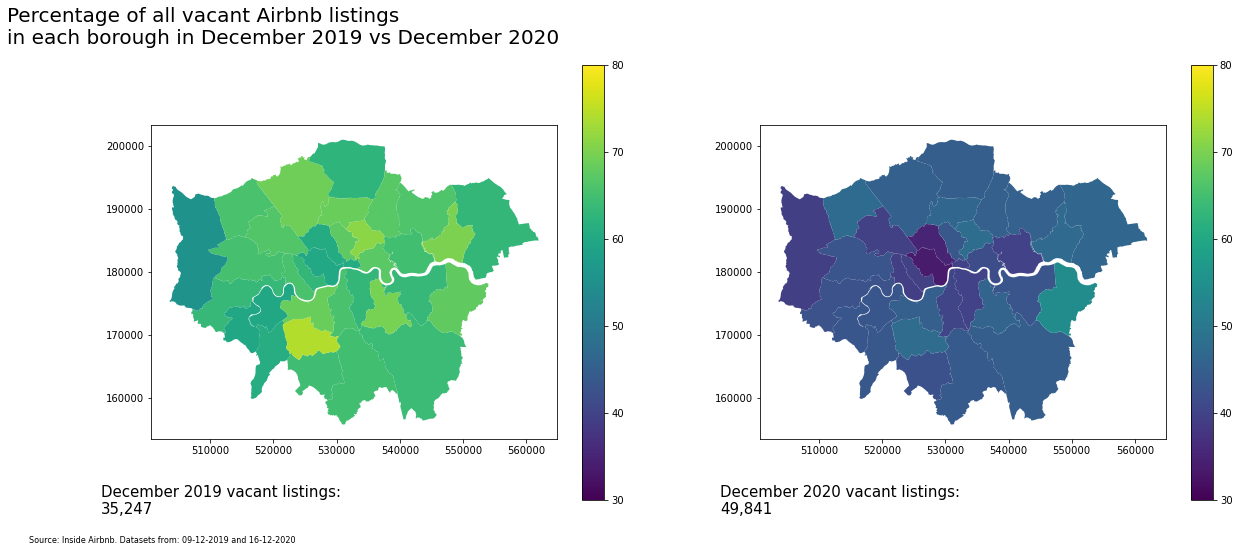

In [136]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,2, figsize=(20,8))
vmin, vmax = 30, 80

# Plot all three to the same axes
fig.suptitle('Percentage of all vacant Airbnb listings\nin each borough in December 2019 vs December 2020', x=0.025, ha='left', size=20)
boros.plot(ax=ax[1],column='pc_vacant_19', legend=True, vmin=vmin, vmax=vmax)
boros.plot(ax=ax[0],column='pc_vacant_20', legend=True, vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"December 2019 vacant listings:\n{dec_19_la.vacant.sum():,.0f}", size=15)
plt.figtext(x=0.52, y=0.1, s=f"December 2020 vacant listings:\n{dec_20_la.vacant.sum():,.0f}", size=15)
plt.figtext(x=0.04, y = 0.05, s = 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020', size =8)

# Set the limits
#ax.set_xlim(500000,565000)
#ax.set_ylim(155000,201000)
#plt.axis('off')

The above plot doesn't really tell us much, so I am going to aggregate professional listings and humble listings aggregated at borough level to see what the proportions are of each type of listing.

In [104]:
dec_20_la.columns

Index(['id', 'listing_url', 'name', 'description', 'host_id', 'host_about',
       'host_listings_count', 'latitude', 'longitude', 'property_type',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'occupancy',
       'occupancy_year', 'earnings', 'earnings_year', 'vacant', 'pro_eh',
       'pro_pr', 'all_pros', 'humble', 'all_vacant_pros', 'all_vacant_humble',
       'is_professional', 'geometry', 'NAME', 'GSS_CODE'],
      dtype='object')

In [111]:
humble_20_agg = dec_20_la.groupby('GSS_CODE').agg({'humble': ['count', 'sum']})
humble_20_agg.columns = humble_20_agg.columns.droplevel(0)
humble_20_agg['pc_humble_20'] = humble_20_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, humble_20_agg, left_on='GSS_CODE', right_index=True)

In [113]:
humble_19_agg = dec_19_la.groupby('GSS_CODE').agg({'humble': ['count', 'sum']})
humble_19_agg.columns = humble_19_agg.columns.droplevel(0)
humble_19_agg['pc_humble_19'] = humble_19_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, humble_19_agg, left_on='GSS_CODE', right_index=True)

Text(0.04, 0.05, 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020')

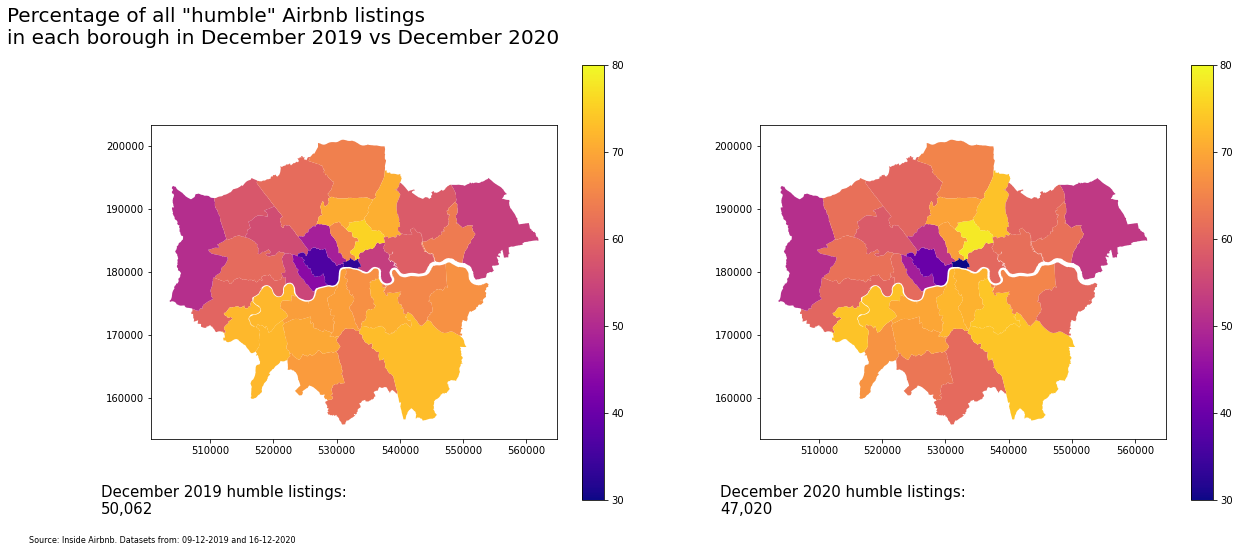

In [135]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,2, figsize=(20,8))
vmin, vmax = 30, 80

# Plot all three to the same axes
fig.suptitle('Percentage of all "humble" Airbnb listings\nin each borough in December 2019 vs December 2020', x=0.025, ha='left', size=20)
boros.plot(ax=ax[1],column='pc_humble_20', legend=True, vmin=vmin, vmax=vmax, cmap='plasma')
boros.plot(ax=ax[0],column='pc_humble_19', legend=True, vmin=vmin, vmax=vmax, cmap='plasma')
plt.figtext(x=0.09, y=0.1, s=f"December 2019 humble listings:\n{dec_19_la.humble.sum():,.0f}", size=15)
plt.figtext(x=0.52, y=0.1, s=f"December 2020 humble listings:\n{dec_20_la.humble.sum():,.0f}", size=15)
plt.figtext(x=0.04, y = 0.05, s = 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020', size =8)

# Set the limits
#ax.set_xlim(500000,565000)
#ax.set_ylim(155000,201000)
#plt.axis('off')

So this map is more intuitive since we can see that the 'humble' listings have a higher proportion of the total listings in boroughs around the periphery of Central London. We can see that the dark clusters in the central boroughs have low % of humble listings which suggests that their is a dominance of professional listings in central london.

In [123]:
pro_20_agg = dec_20_la.groupby('GSS_CODE').agg({'all_pros': ['count', 'sum']})
pro_20_agg.columns = pro_20_agg.columns.droplevel(0)
pro_20_agg['pc_pro_20'] = pro_20_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, pro_20_agg, left_on='GSS_CODE', right_index=True)

In [124]:
pro_19_agg = dec_19_la.groupby('GSS_CODE').agg({'all_pros': ['count', 'sum']})
pro_19_agg.columns = pro_19_agg.columns.droplevel(0)
pro_19_agg['pc_pro_19'] = pro_19_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, pro_19_agg, left_on='GSS_CODE', right_index=True)

Text(0.04, 0.05, 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020')

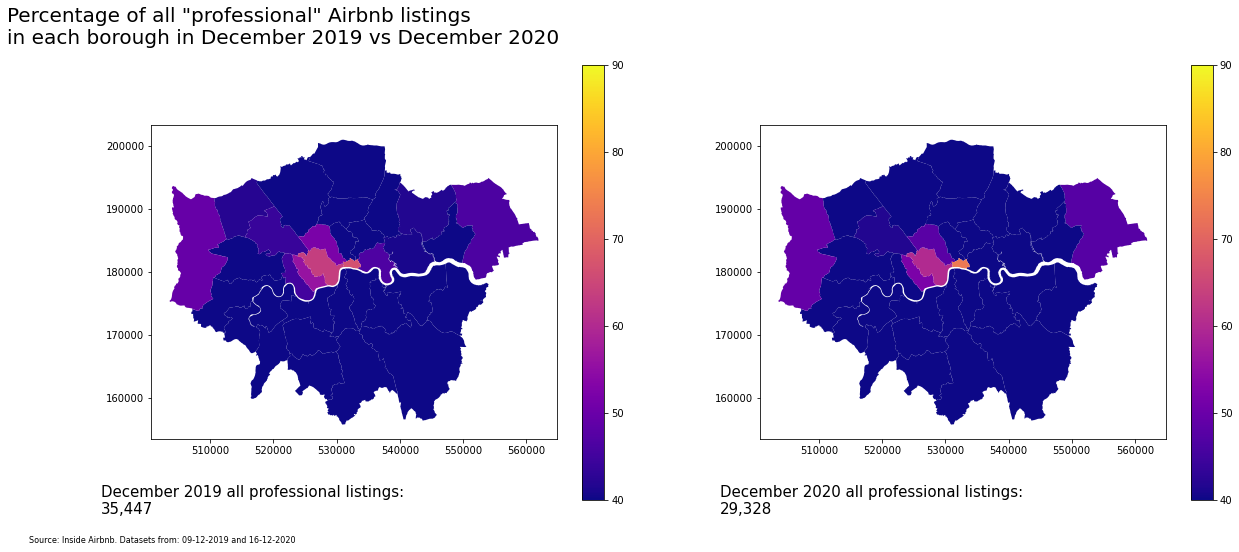

In [134]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,2, figsize=(20,8))
vmin, vmax = 40, 90

# Plot all three to the same axes
fig.suptitle('Percentage of all "professional" Airbnb listings\nin each borough in December 2019 vs December 2020', x=0.025, ha='left', size=20)
boros.plot(ax=ax[1],column='pc_pro_20', legend=True, vmin=vmin, vmax=vmax, cmap='plasma')
boros.plot(ax=ax[0],column='pc_pro_19', legend=True, vmin=vmin, vmax=vmax, cmap='plasma')
plt.figtext(x=0.09, y=0.1, s=f"December 2019 all professional listings:\n{dec_19_la.all_pros.sum():,.0f}", size=15)
plt.figtext(x=0.52, y=0.1, s=f"December 2020 all professional listings:\n{dec_20_la.all_pros.sum():,.0f}", size=15)
plt.figtext(x=0.04, y = 0.05, s = 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020', size =8)

# Set the limits
#ax.set_xlim(500000,565000)
#ax.set_ylim(155000,201000)
#plt.axis('off')

This plot illustrates the agglomeration of professional listings in Central London Boroughs. We can see that the professional listings cluster in central with the remaining proportion of listings evenly spread between 40-50%.

**Now going to have an explore at MSOA level to see what the spatial patterns are:**

In [144]:
dec_20_msoa = gpd.sjoin(dec_20_la, msoas, op='within')

In [142]:
dec_19_msoa = gpd.sjoin(dec_19_la, msoas, op='within')

Looking at humble listings at MSOA level:

In [148]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'Borough',
       'msoa11hclnm', 'geometry'],
      dtype='object')

In [149]:
humble_20_agg = dec_20_msoa.groupby('MSOA11CD').agg({'humble': ['count', 'sum']})
humble_20_agg.columns = humble_20_agg.columns.droplevel(0)
humble_20_agg['pc_humble_20'] = humble_20_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
msoas = pd.merge(msoas, humble_20_agg, left_on='MSOA11CD', right_index=True)

In [150]:
humble_19_agg = dec_19_msoa.groupby('MSOA11CD').agg({'humble': ['count', 'sum']})
humble_19_agg.columns = humble_19_agg.columns.droplevel(0)
humble_19_agg['pc_humble_19'] = humble_19_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
msoas = pd.merge(msoas, humble_19_agg, left_on='MSOA11CD', right_index=True)

Text(0.04, 0.05, 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020')

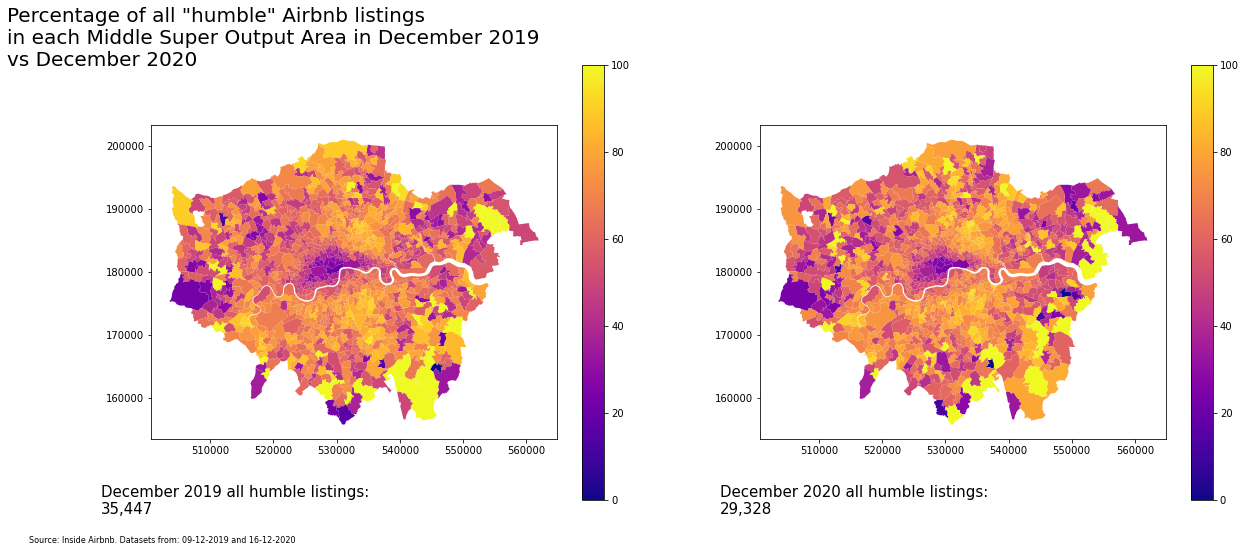

In [151]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,2, figsize=(20,8))
vmin, vmax = 40, 90
#vmin=vmin, vmax=vmax,

# Plot all three to the same axes
fig.suptitle('Percentage of all "humble" Airbnb listings\nin each Middle Super Output Area in December 2019\nvs December 2020', x=0.025, ha='left', size=20)
msoas.plot(ax=ax[1],column='pc_humble_20', legend=True,  cmap='plasma')
msoas.plot(ax=ax[0],column='pc_humble_19', legend=True,  cmap='plasma')
plt.figtext(x=0.09, y=0.1, s=f"December 2019 all humble listings:\n{dec_19_la.all_pros.sum():,.0f}", size=15)
plt.figtext(x=0.52, y=0.1, s=f"December 2020 all humble listings:\n{dec_20_la.all_pros.sum():,.0f}", size=15)
plt.figtext(x=0.04, y = 0.05, s = 'Source: Inside Airbnb. Datasets from: 09-12-2019 and 16-12-2020', size =8)

# Set the limits
#ax.set_xlim(500000,565000)
#ax.set_ylim(155000,201000)
#plt.axis('off')

In [ ]:
##ignore all below for now!!

In [ ]:
# now plot the points onto our borough map
fig, ax = plt.subplots(1,1, figsize=(50,45))

# Plot all three to the same axes
boros.plot(ax=ax,edgecolor="gray", facecolor="white", linewidth=1)
all_pros_19_geo.plot(ax=ax,color="black", alpha=0.6, markersize=10)
all_pros_20_geo.plot(ax=ax,color="pink", alpha=0.9, markersize=10)

# Set the limits
ax.set_xlim(500000,565000)
ax.set_ylim(155000,201000)
plt.axis('off')